In [436]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
import language_tool_python
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, cohen_kappa_score

language_tool = language_tool_python.LanguageTool('en-US')
stop_words = stopwords.words('english')

In [303]:
df = pd.read_excel("training_set_rel3.xls")
df.head()
df.shape

(12978, 28)

In [304]:
from sklearn.model_selection import train_test_split

df = df[df["essay_set"]==1]

train, test= train_test_split(df, train_size=0.8, test_size=0.2, random_state=420)

train.to_csv("train_set.csv", index=False)
test.to_csv("test_set.csv", index=False)

In [305]:
# dataset for Regression
reg_train = train.copy()
reg_test = test.copy()

print(f"reg_train shape: {reg_train.shape}")
print(f"reg_test shape: {reg_test.shape}")

reg_train shape: (1426, 28)
reg_test shape: (357, 28)


In [306]:
# essay structure
import re
import nltk

def word_count(essay):
    clean_essay = re.sub(r'\W', ' ', essay)
    words = nltk.word_tokenize(essay)

    return len(words)

def unique_word_count(essay):
    clean_essay = re.sub(r'\W', ' ', essay)
    words = nltk.word_tokenize(clean_essay)
    unique_words = set(words)

    return len(unique_words)

def sentence_count(essay):
    sentences = nltk.sent_tokenize(essay)
    
    return len(sentences)

def avg_word_len(essay):
    clean_essay = re.sub(r'\W', ' ', essay)
    words = nltk.word_tokenize(clean_essay)
    
    return sum(len(word) for word in words) / len(words)

# get grammar errors
def grammar_errors(essay):
    errors = language_tool.check(essay)
    return len(errors)

# fix errors
def autocorrect_essay(essay):
    corrected_essay = language_tool.correct(essay)
    return corrected_essay

In [307]:
def preprocess_reg_dataframe(df, essay_set):
    clean_df = pd.DataFrame()

    # get the essays
    print("Getting Essay")
    clean_df = clean_df.assign(essay=df['essay'])
    print("Getting Actual Score")
    clean_df = clean_df.assign(actual_score=df['domain1_score'])
    clean_df = clean_df.reset_index(drop=True)

    # get essay structure
    print("Getting Word Count")
    clean_df['word_count'] = clean_df['essay'].apply(word_count)
    print("Getting Unique Word Count")
    clean_df['unique_word_count'] = clean_df['essay'].apply(unique_word_count)
    print("Getting Sentence Count")
    clean_df['sentence_count'] = clean_df['essay'].apply(sentence_count)
    print("Getting Average Word Length")
    clean_df['avg_word_len'] = clean_df['essay'].apply(avg_word_len)

    # get grammatical errors
    print("Getting Grammatical Errors")
    clean_df['grammar_errors'] = clean_df['essay'].apply(grammar_errors)
    
    # autocorrect errors
    print("Autocorrecting Essay")
    clean_df['essay'] = clean_df['essay'].apply(autocorrect_essay)

    # preprocess essay for tokenization
    print("Preprocess for tokenization")
    clean_df['essay'] = clean_df['essay'].str.replace("[^a-zA-Z#]", " ")
    clean_df['essay'] = clean_df['essay'].apply(lambda x: x.lower())

    # tokenization
    print("Tokenization Start")
    tokenized_doc = clean_df['essay'].apply(lambda x: x.split())

    # remove stop-words
    print("Removing Stop Words")
    tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

    # stemming
    print("Word Stemming")
    porter_stemmer = PorterStemmer()
    tokenized_doc = tokenized_doc.apply(lambda x: [porter_stemmer.stem(item) for item in x])

    # de-tokenization
    print("Detokenize")
    detokenized_doc = []
    for i in range(len(clean_df)):
        t = ' '.join(tokenized_doc[i])
        detokenized_doc.append(t)

    clean_df['essay'] = detokenized_doc

    return clean_df

In [321]:
def preprocess_lsa_dataframe(df, essay_set):
    clean_df = df.copy()
    score_index = df[df['actual_score'] <= 10].index
    clean_df.drop(score_index, inplace=True)

    return(clean_df)

In [ ]:
reg_train = preprocess_reg_dataframe(reg_train, 1)
print(f"Reg Train Dataset Shape: {reg_train.shape}\n")

reg_test = preprocess_reg_dataframe(reg_test, 1)
print(f"Reg Test Dataset Shape: {reg_test.shape}")

In [339]:
lsa_train = preprocess_lsa_dataframe(reg_train, 1)
print(f"LSA Train Dataset Shape: {lsa_train.shape}\n")

df_test = reg_test.copy()
print(f"Df Test Dataset Shape: {df_test.shape}")

LSA Train Dataset Shape: (124, 7)

Df Test Dataset Shape: (357, 7)


In [340]:
lsa_train['actual_score'].value_counts()

11    89
12    35
Name: actual_score, dtype: int64

In [341]:
# Create a vectorizer for the training data
tokenizer = RegexpTokenizer(r'\w+')

# Vectorize document using TF-IDF
tfidf_vectorizer = TfidfVectorizer(lowercase=True,
                                        stop_words='english',
                                        ngram_range = (1,3),
                                        tokenizer = tokenizer.tokenize,
                                        max_features=1000,
                                        max_df=0.8,
                                        min_df=5)

tfidf_matrix = tfidf_vectorizer.fit_transform(lsa_train["essay"])
print(f"Train TFIDF Matrix Shape: {tfidf_matrix.shape}")

Train TFIDF Matrix Shape: (124, 1000)


In [342]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

# TFIDF to SVD
svd_model = TruncatedSVD(n_components=100,
                         n_iter=200,
                         random_state=69)
    
svd = svd_model.fit_transform(tfidf_matrix)
normalized_svd = Normalizer(copy=False).fit_transform(svd)

In [452]:
print(type(svd))
print(normalized_svd.ravel())

<class 'numpy.ndarray'>
[ 0.45955529 -0.23828101 -0.01593293 ...  0.01862716 -0.07432656
  0.0475013 ]


In [343]:
from sklearn.metrics.pairwise import cosine_similarity

def lsa_score(essay):
    essay_matrix = tfidf_vectorizer.transform([essay])

    essay_svd = svd_model.transform(essay_matrix)
    normalized_essay_svd = Normalizer(copy=False).fit_transform(essay_svd)

    similarities = cosine_similarity(normalized_svd, normalized_essay_svd).max()

    return similarities.max()

In [344]:
df_test['lsa_score'] = df_test['essay'].apply(lsa_score)

df_test.head(20)

,essay,actual_score,word_count,unique_word_count,sentence_count,avg_word_len,grammar_errors,lsa_score
0,dear local newspap cap year comput exist mani ...,10,471,206,24,4.549161,7,0.576448
1,month concern cap mani hour day spend comput m...,8,218,115,10,4.515789,5,0.487281
2,dear organ resent concern built among expert c...,12,696,271,44,4.335484,54,0.621460
3,dear local newspap comput use everyday million...,8,410,143,28,4.552198,6,0.729920
4,dear local newspap cap name person inform peop...,10,685,315,47,4.372617,34,0.544884
5,dear cap cap cap cap averag teenag spend num h...,10,590,254,36,4.571429,25,0.686491
6,believ comput make everyday work easier comput...,9,377,168,19,4.297376,4,0.549576
7,dear local newspap think comput great sourc he...,8,382,170,27,3.997135,19,0.459226
8,dear newspap write persuad put articl paper co...,8,369,140,22,4.404762,10,0.572845
9,date cap cap believ comput today societi possi...,8,285,132,17,4.463415,15,0.603146


In [345]:
def predicted_score(lsa_score):
    total = 12
    score = total * lsa_score
    return int(score)

In [346]:
df_test['predicted_lsa_score'] = df_test['lsa_score'].apply(predicted_score)
df_test.head(20)

,essay,actual_score,word_count,unique_word_count,sentence_count,avg_word_len,grammar_errors,lsa_score,predicted_lsa_score
0,dear local newspap cap year comput exist mani ...,10,471,206,24,4.549161,7,0.576448,6
1,month concern cap mani hour day spend comput m...,8,218,115,10,4.515789,5,0.487281,5
2,dear organ resent concern built among expert c...,12,696,271,44,4.335484,54,0.621460,7
3,dear local newspap comput use everyday million...,8,410,143,28,4.552198,6,0.729920,8
4,dear local newspap cap name person inform peop...,10,685,315,47,4.372617,34,0.544884,6
5,dear cap cap cap cap averag teenag spend num h...,10,590,254,36,4.571429,25,0.686491,8
6,believ comput make everyday work easier comput...,9,377,168,19,4.297376,4,0.549576,6
7,dear local newspap think comput great sourc he...,8,382,170,27,3.997135,19,0.459226,5
8,dear newspap write persuad put articl paper co...,8,369,140,22,4.404762,10,0.572845,6
9,date cap cap believ comput today societi possi...,8,285,132,17,4.463415,15,0.603146,7


c:\Users\Chaldea\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='lsa_score', ylabel='actual_score'>

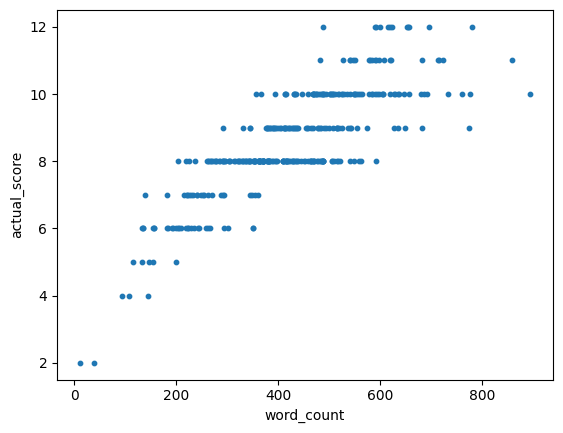

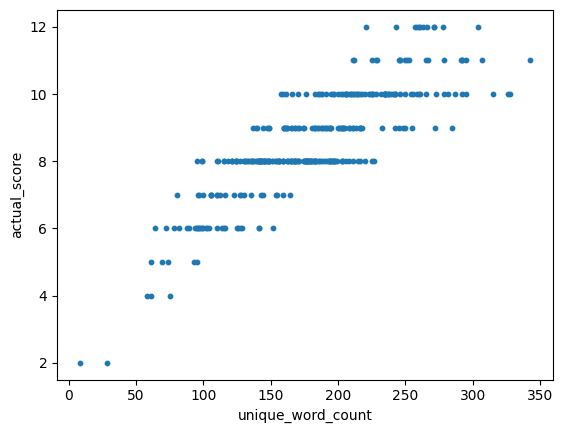

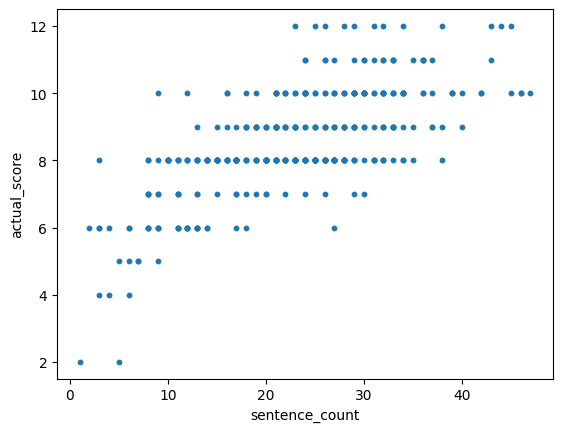

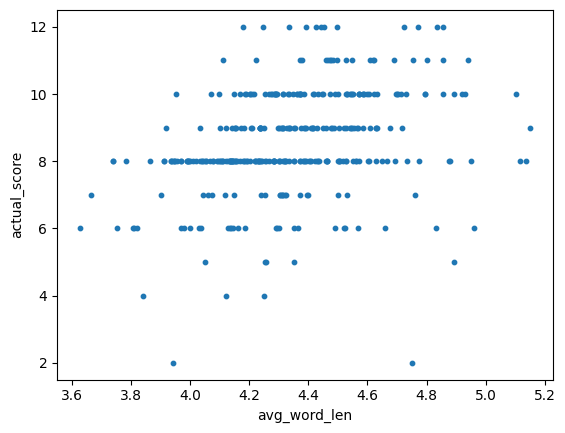

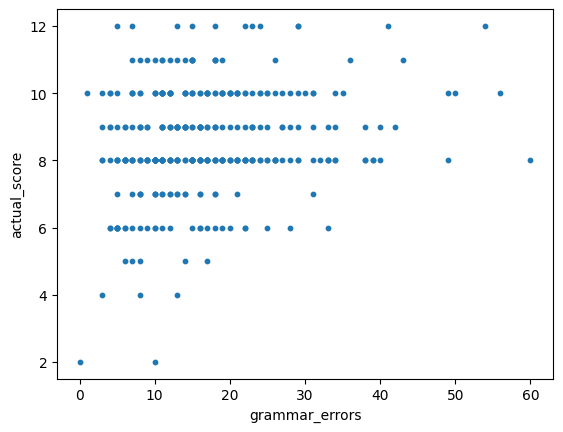

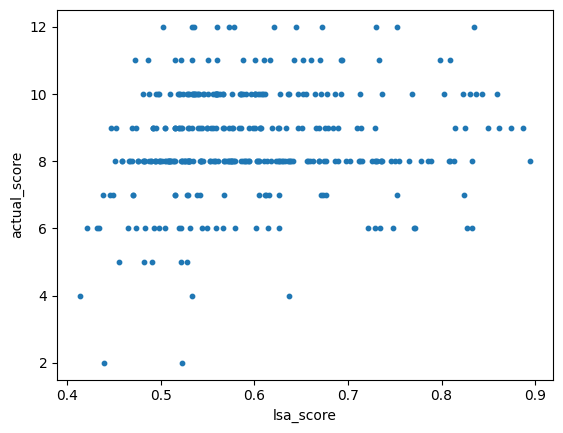

In [347]:
# Exploratory Data Analysis (EDA) on the data
import matplotlib.pyplot as plt
%matplotlib inline

feature_names = df_test[['word_count', 'unique_word_count', 'sentence_count', 'avg_word_len', 'grammar_errors', 'lsa_score', 'actual_score']]

feature_names.plot.scatter(x="word_count", y='actual_score', s=10)
feature_names.plot.scatter(x="unique_word_count", y='actual_score', s=10)
feature_names.plot.scatter(x="sentence_count", y='actual_score', s=10)
feature_names.plot.scatter(x="avg_word_len", y='actual_score', s=10)
feature_names.plot.scatter(x="grammar_errors", y='actual_score', s=10)
feature_names.plot.scatter(x="lsa_score", y='actual_score', s=10)

In [348]:
df_test['actual_score'].value_counts()

8     132
10     71
9      62
6      28
7      22
11     20
12     12
5       5
4       3
2       2
Name: actual_score, dtype: int64

In [349]:
df_test['predicted_lsa_score'].value_counts()

6     139
7      84
5      53
8      46
9      25
10      9
4       1
Name: predicted_lsa_score, dtype: int64

In [437]:
mae = mean_absolute_error(df_test['actual_score'], df_test['predicted_lsa_score'])
mse = mean_squared_error(df_test['actual_score'], df_test['predicted_lsa_score'])
rmse = np.sqrt(mse)
kappa = cohen_kappa_score(df_test['actual_score'], df_test['predicted_lsa_score'])


print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Kappa score: {kappa}")

Mean Absolute Error: 2.2324929971988796
Mean Squared Error: 7.061624649859944
Root Mean Squared Error: 2.657371756051446
Kappa score: 0.006405725393178963


In [351]:
# linear regression, LogisticRegression, SVR
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

x_train = reg_train[['word_count', 'unique_word_count', 'sentence_count', 'avg_word_len','grammar_errors']]
y_train = reg_train['actual_score']

x_test = reg_test[['word_count', 'unique_word_count', 'sentence_count', 'avg_word_len','grammar_errors']]
y_test = reg_test['actual_score']

In [362]:
print("Building Linear Regression Model")
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

print("Building Logistic Regression Model")
log_model = LogisticRegression(solver="saga", max_iter=10000)
log_model.fit(x_train, y_train)

print("Building SVR Model")
svr_model = SVR()
svr_model.fit(x_train, y_train)

print("Building Decision Tree Model")
tree_model = DecisionTreeRegressor()
tree_model.fit(x_train, y_train)

Building Linear Regression Model
Building Logistic Regression Model
Building SVR Model
Building Decision Tree Model


DecisionTreeRegressor()

In [363]:
predictions = [lr_model.predict(x_test),
               log_model.predict(x_test),
               svr_model.predict(x_test),
               tree_model.predict(x_test)]

In [444]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

for idx, pred in enumerate(predictions):
    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    r_score = r2_score(y_test, pred)

    print(f"Model {idx}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"R2 score: {r_score}\n")

Model 0
Mean Absolute Error: 0.6659648409438481
Mean Squared Error: 0.7042407014013922
Root Mean Squared Error: 0.8391905036410935
R2 score: 0.7238688511312128

Model 1
Mean Absolute Error: 0.8151260504201681
Mean Squared Error: 1.5098039215686274
Root Mean Squared Error: 1.2287407869720235
R2 score: 0.4080093771920108

Model 2
Mean Absolute Error: 0.63631369350195
Mean Squared Error: 0.6310664996018261
Root Mean Squared Error: 0.79439694083111
R2 score: 0.7525602862758483

Model 3
Mean Absolute Error: 0.7366946778711485
Mean Squared Error: 1.072829131652661
Root Mean Squared Error: 1.0357746529301926
R2 score: 0.5793461808247498



In [411]:
def predict_reg_score(features):
    y_pred = svr_model.predict(features)
    return round(y_pred[0])

In [427]:
# the SVR model is the best performing model
['word_count', 'unique_word_count', 'sentence_count', 'avg_word_len','grammar_errors']
for idx, row in df_test.iterrows():
    data = {
        'word_count':[row['word_count']],
        'unique_word_count':[row['unique_word_count']],
        'sentence_count':[row['sentence_count']],
        'avg_word_len':[row['avg_word_len']],
        'grammar_errors':[row['grammar_errors']]
    }

    x_features = pd.DataFrame(data)
    df_test.loc[idx,'predicted_reg_score'] = predict_reg_score(x_features)


In [428]:
df_test.head(25)

,essay,actual_score,word_count,unique_word_count,sentence_count,avg_word_len,grammar_errors,lsa_score,predicted_lsa_score,predicted_reg_score
0,dear local newspap cap year comput exist mani ...,10,471,206,24,4.549161,7,0.576448,6,9.0
1,month concern cap mani hour day spend comput m...,8,218,115,10,4.515789,5,0.487281,5,7.0
2,dear organ resent concern built among expert c...,12,696,271,44,4.335484,54,0.621460,7,11.0
3,dear local newspap comput use everyday million...,8,410,143,28,4.552198,6,0.729920,8,8.0
4,dear local newspap cap name person inform peop...,10,685,315,47,4.372617,34,0.544884,6,11.0
5,dear cap cap cap cap averag teenag spend num h...,10,590,254,36,4.571429,25,0.686491,8,10.0
6,believ comput make everyday work easier comput...,9,377,168,19,4.297376,4,0.549576,6,8.0
7,dear local newspap think comput great sourc he...,8,382,170,27,3.997135,19,0.459226,5,8.0
8,dear newspap write persuad put articl paper co...,8,369,140,22,4.404762,10,0.572845,6,8.0
9,date cap cap believ comput today societi possi...,8,285,132,17,4.463415,15,0.603146,7,7.0


In [432]:
df_test[df_test['predicted_reg_score'] <= 5]

,essay,actual_score,word_count,unique_word_count,sentence_count,avg_word_len,grammar_errors,lsa_score,predicted_lsa_score,predicted_reg_score
58,think comput good use find place anoth reason ...,4,106,61,6,3.840000,3,0.413466,4,5.0
81,dear newspap think comput great research thing...,6,132,78,6,4.658333,7,0.504252,6,5.0
95,activ limit technolog,2,10,8,1,4.750000,0,0.522527,6,3.0
166,think comput posit effect peopl comput import ...,6,135,72,9,4.364407,8,0.721487,8,5.0
180,dear cap cap cap name person concern peopl aro...,5,132,74,6,4.049587,17,0.455182,5,5.0
267,peopl like comput instant reason peopl like co...,4,145,75,4,4.250000,8,0.637115,7,5.0
294,dear local newspap write tell think comput goo...,5,115,61,5,4.894231,6,0.481854,5,5.0
316,peopl probabl comput chart e mail make websit ...,4,93,58,3,4.120879,13,0.533203,6,5.0
323,comput cool websit num com need time left lo m...,2,39,28,5,3.941176,10,0.439433,5,4.0
324,think comput good need rememb stuff look email...,6,134,64,2,3.820312,17,0.431831,5,5.0
